<a href="https://colab.research.google.com/github/khadir786/phishing_ml/blob/main/80-20%20Split%20Spam%20Detection%20Using%20Machine%20Learning%20Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining the Effectiveness of Various Machine Learning Classifiers



The goal of this notebook is to determine the effectiveness of the SVM, Decision Tree, Naive Bayes. Random Forest, K-Nearest Neighbors and Logistic Regression classifiers respectively. The dataset used is from the Enron Corpus.



## Imports

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Load dataset

The dataset is loaded and rows that have missing values are dropped. This is justified when the scale of the dataset is considered.

In [3]:
url = "https://raw.githubusercontent.com/khadir786/phishing_ml/main/data/enron_spam_data.csv"
# Load the data from the CSV file
df = pd.read_csv(url)
df.shape

(33716, 5)

## Data Preprocessing and Splitting

In [4]:
# Check for missing data
print(df.isnull().sum())

Message ID      0
Subject       289
Message       371
Spam/Ham        0
Date            0
dtype: int64


In [5]:
# Drop rows with missing values in "Subject" and "Message" columns
df = df.dropna(subset=["Subject", "Message"])
# Check for missing data
print(df.isnull().sum())

Message ID    0
Subject       0
Message       0
Spam/Ham      0
Date          0
dtype: int64


In [6]:
df.shape

(33107, 5)

In [7]:
ham_prec_scores = []
spam_prec_scores = []
ham_f1_scores = []
spam_f1_scores = []
accuracy_scores = []
models = ['Support Vector Machine', 'Decision Tree', 'Multinomial Naive Bayes', 'Random Forest', 'K-NearestNeighbors', 'Logistic Regression']

### Split data into features and labels

Convert the "Spam/Ham" column to binary labels (0 for ham, 1 for spam)

In [8]:
df["Spam/Ham"] = df["Spam/Ham"].apply(lambda x: 0 if x == "ham" else 1)

The "Subject" and "Message" columns are concatenated to create one email content feature.  

In [9]:
# Concatenate the "Subject" and "Message" columns to create combined email content
df['email_content'] = df['Subject'].str.cat(df['Message'], sep=' ')

Each word is tokenized and lemmatized to collapse similar words into a single representaion

In [10]:
# For tokenization
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Tokenize and lemmatize the text data
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized_tokens)

# Apply tokenization and lemmatization on the email content
df['email_content'] = df['email_content'].apply(tokenize_and_lemmatize)

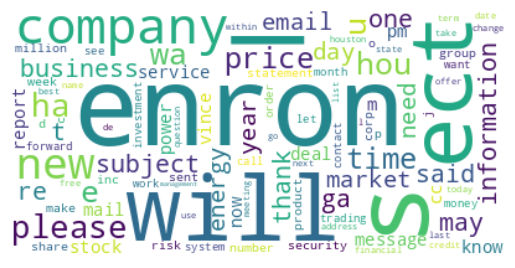

In [12]:
df['email_content'] = df['email_content'].astype(str)
text = " ".join(word for word in df['email_content'])
wordcloud = WordCloud(max_words=100, background_color="white", collocations=False).generate(text)
# Display the generated wordcloud image
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
# Split the data into features (email_content) and labels (spam/ham)
X = df["email_content"]
y = df["Spam/Ham"]

In [14]:
print(df["Spam/Ham"].unique())

[0 1]


### Split Data into Testing Data and Training Data

Since the goal of this project is to test the performance of classifiers/models (and because the dataset is relatively large), I opted to split the training and testing set to 50:50 ratio.
Stratified sampling is used to keep the distribution of spam and ham emails about the same in each dataset.

In [15]:
# Convert the text into numerical features using a Bag-of-Words model
stopWords = list(ENGLISH_STOP_WORDS) + ["ect", "hou", "s", "ga", "cc"]
vectorizer = CountVectorizer(stop_words=stopWords)
X = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify=y)
X_train.shape, X_test.shape

((26485, 149269), (6622, 149269))

In [16]:
# Get the count of features
feature_count = len(vectorizer.vocabulary_)

print("Number of features: ", feature_count)

Number of features:  149269


## Creating the Classifiers and Training the Data



---



### Support Vector Machine

In [17]:
# Create an SVM classifier and fit it with the training data
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [18]:
# Predict the labels for the testing data
y_pred = svm_model.predict(X_test)

# Evaluate the performance of the classifier
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3299
           1       0.98      0.99      0.99      3323

    accuracy                           0.99      6622
   macro avg       0.99      0.99      0.99      6622
weighted avg       0.99      0.99      0.99      6622



In [19]:
# Perform 10-fold cross-validation and obtain the accuracy scores
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10)

svm_cv_mean = svm_cv_scores.mean()
svm_cv_st = svm_cv_scores.std()

# Calculate the mean and standard deviation of the accuracy scores
print("Cross-validation accuracy scores: ", svm_cv_scores)
print("Mean accuracy: ", svm_cv_scores.mean())
print("Standard deviation: ", svm_cv_scores.std())

Cross-validation accuracy scores:  [0.98338996 0.98565496 0.98301246 0.98565496 0.98603247 0.98753776
 0.99018127 0.98867069 0.98791541 0.98942598]
Mean accuracy:  0.9867475927186797
Standard deviation:  0.002297268166223781


In [20]:
# Train SVM model using 5-fold cross validation 
y_pred_svm = cross_val_predict(svm_model, X, y, cv=5)

In [21]:
# Evaluate the performance of the classifier using classification report
svm_report = classification_report(y, y_pred_svm)
print(svm_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     16493
           1       0.97      0.99      0.98     16614

    accuracy                           0.98     33107
   macro avg       0.98      0.98      0.98     33107
weighted avg       0.98      0.98      0.98     33107



In [22]:
# Convert report to dictionary
svm_report = classification_report(y, y_pred_svm, output_dict=True)

print(svm_report)

{'0': {'precision': 0.9877281697089294, 'recall': 0.9711392712059662, 'f1-score': 0.9793634779418509, 'support': 16493}, '1': {'precision': 0.9718193120596768, 'recall': 0.988022149993981, 'f1-score': 0.9798537531711685, 'support': 16614}, 'accuracy': 0.979611562509439, 'macro avg': {'precision': 0.979773740884303, 'recall': 0.9795807105999736, 'f1-score': 0.9796086155565097, 'support': 33107}, 'weighted avg': {'precision': 0.9797446689089572, 'recall': 0.979611562509439, 'f1-score': 0.9796095114894354, 'support': 33107}}


In [23]:
# Append precision and f1-score to their respective lists
ham_prec_scores.append(round(svm_report['0']['precision'], 3)) 
spam_prec_scores.append(round(svm_report['1']['precision'], 3))
ham_f1_scores.append(round(svm_report['0']['f1-score'], 3))
spam_f1_scores.append(round(svm_report['1']['f1-score'], 3))
accuracy_scores.append(round(svm_report['accuracy'], 3))



---



### Decision Tree 

In [24]:
# Train the Decision Tree classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
# Predict the labels for the testing data
y_pred_dt = dt_model.predict(X_test)

# Evaluate the performance of the Decision Tree model using classification report
dt_report = classification_report(y_test, y_pred_dt)
print("Decision Tree Classification Report:")
print(dt_report)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3299
           1       0.96      0.97      0.97      3323

    accuracy                           0.97      6622
   macro avg       0.97      0.97      0.97      6622
weighted avg       0.97      0.97      0.97      6622





---



In [26]:
# Perform 10-fold cross-validation and obtain the accuracy scores
dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=10)

dt_cv_mean = dt_cv_scores.mean()
dt_cv_st = dt_cv_scores.std()

# Calculate the mean and standard deviation of the accuracy scores
print("Cross-validation accuracy scores: ", dt_cv_scores)
print("Mean accuracy: ", dt_cv_mean)
print("Standard deviation: ", dt_cv_st)

Cross-validation accuracy scores:  [0.95016988 0.9580974  0.9584749  0.9603624  0.95734239 0.96261329
 0.95430514 0.95770393 0.9592145  0.96714502]
Mean accuracy:  0.9585428834229187
Standard deviation:  0.004298144841250693


In [27]:
# Train Decision Tree model using 5-fold cross validation 
y_pred_dt = cross_val_predict(dt_model, X, y, cv=5)

# Evaluate the performance of the classifier using classification report
dt_report = classification_report(y, y_pred_dt)
print(dt_report)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     16493
           1       0.93      0.97      0.95     16614

    accuracy                           0.94     33107
   macro avg       0.94      0.94      0.94     33107
weighted avg       0.94      0.94      0.94     33107



In [28]:
# Convert report to dictionary
dt_report = classification_report(y, y_pred_dt, output_dict=True)

# Append precision and f1-score to their respective lists
ham_prec_scores.append(round(dt_report['0']['precision'], 3)) 
spam_prec_scores.append(round(dt_report['1']['precision'], 3))
ham_f1_scores.append(round(dt_report['0']['f1-score'], 3))
spam_f1_scores.append(round(dt_report['1']['f1-score'], 3))
accuracy_scores.append(round(dt_report['accuracy'], 3))

### Naive Bayes

Since I am using a Bag-of-Words model to convert the text features into numerical features, the features are discrete and the Multinomial Naive Bayes classifier should be used.

In [29]:
# Train the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [30]:
# Predict the labels for the testing data
y_pred_nb = nb_model.predict(X_test)

# Evaluate the performance of the Multinomial Naive Bayes model using classification report
nb_report = classification_report(y_test, y_pred_nb)
print("Multinomial Naive Bayes Report:")
print(nb_report)

Multinomial Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3299
           1       0.99      0.99      0.99      3323

    accuracy                           0.99      6622
   macro avg       0.99      0.99      0.99      6622
weighted avg       0.99      0.99      0.99      6622



In [31]:
# Perform 10-fold cross-validation and obtain the accuracy scores
nb_cv_scores = cross_val_score(nb_model, X_train, y_train, cv=10)

nb_cv_mean = nb_cv_scores.mean()
nb_cv_st = nb_cv_scores.std()

# Calculate the mean and standard deviation of the accuracy scores
print("Cross-validation accuracy scores: ", nb_cv_scores)
print("Mean accuracy: ", nb_cv_mean)
print("Standard deviation: ", nb_cv_st)

Cross-validation accuracy scores:  [0.98829747 0.98716497 0.98980747 0.98905247 0.99056248 0.98753776
 0.98791541 0.99206949 0.98716012 0.99093656]
Mean accuracy:  0.9890504197559586
Standard deviation:  0.001637168092242872


In [32]:
# Train Multinomial Naive Bayes model using 5-fold cross validation 
y_pred_nb = cross_val_predict(nb_model, X, y, cv=5)

# Evaluate the performance of the classifier using classification report
nb_report = classification_report(y, y_pred_nb)
print(nb_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     16493
           1       0.98      0.99      0.98     16614

    accuracy                           0.98     33107
   macro avg       0.98      0.98      0.98     33107
weighted avg       0.98      0.98      0.98     33107



In [33]:
# Convert report to dictionary
nb_report = classification_report(y, y_pred_nb, output_dict=True)

# Append precision and f1-score to their respective lists
ham_prec_scores.append(round(nb_report['0']['precision'], 3)) 
spam_prec_scores.append(round(nb_report['1']['precision'], 3))
ham_f1_scores.append(round(nb_report['0']['f1-score'], 3))
spam_f1_scores.append(round(nb_report['1']['f1-score'], 3))
accuracy_scores.append(round(nb_report['accuracy'], 3))

### Random Forest

In [34]:
# Train the Random Forest classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
# Predict the labels for the testing data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the performance of the Random Forest model using classification report
rf_report = classification_report(y_test, y_pred_rf)
print("Random Forest Report:")
print(rf_report)

Random Forest Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3299
           1       0.98      0.99      0.99      3323

    accuracy                           0.99      6622
   macro avg       0.99      0.99      0.99      6622
weighted avg       0.99      0.99      0.99      6622



In [36]:
# Perform 10-fold cross-validation and obtain the accuracy scores
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10)

rf_cv_mean = rf_cv_scores.mean()
rf_cv_st = rf_cv_scores.std()

# Calculate the mean and standard deviation of the accuracy scores
print("Cross-validation accuracy scores: ", rf_cv_scores)
print("Mean accuracy: ", rf_cv_mean)
print("Standard deviation: ", rf_cv_st)

Cross-validation accuracy scores:  [0.98414496 0.98678747 0.98489996 0.98640997 0.98640997 0.98791541
 0.98489426 0.98829305 0.98640483 0.98791541]
Mean accuracy:  0.9864075282355879
Standard deviation:  0.0013389892387090992


In [37]:
# Train Random Forest model using 5-fold cross validation 
y_pred_rf = cross_val_predict(rf_model, X, y, cv=5)

In [38]:
# Evaluate the performance of the classifier using classification report
rf_report = classification_report(y, y_pred_rf)
print(rf_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     16493
           1       0.98      0.99      0.98     16614

    accuracy                           0.98     33107
   macro avg       0.98      0.98      0.98     33107
weighted avg       0.98      0.98      0.98     33107



In [39]:
# Convert report to dictionary
rf_report = classification_report(y, y_pred_rf, output_dict=True)

# Append precision and f1-score to their respective lists
ham_prec_scores.append(round(rf_report['0']['precision'], 3)) 
spam_prec_scores.append(round(rf_report['1']['precision'], 3))
ham_f1_scores.append(round(rf_report['0']['f1-score'], 3))
spam_f1_scores.append(round(rf_report['1']['f1-score'], 3))
accuracy_scores.append(round(rf_report['accuracy'], 3))

### K-Nearest Neighbors

In [40]:
# Train the K-Nearest Neighbors classifer
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
# Predict the labels for the testing data
y_pred_knn = knn_model.predict(X_test)

# Evaluate the performance of the K-Nearest Neighbors model using classification report
knn_report = classification_report(y_test, y_pred_knn)
print("K-Nearest Neighbors Report:")
print(knn_report)

K-Nearest Neighbors Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3299
           1       0.86      0.97      0.91      3323

    accuracy                           0.90      6622
   macro avg       0.91      0.90      0.90      6622
weighted avg       0.91      0.90      0.90      6622



In [42]:
# Perform 10-fold cross-validation and obtain the accuracy scores
knn_cv_scores = cross_val_score(knn_model, X_train, y_train, cv=10)

knn_cv_mean = knn_cv_scores.mean()
knn_cv_st = knn_cv_scores.std()

# Calculate the mean and standard deviation of the accuracy scores
print("Cross-validation accuracy scores: ", knn_cv_scores)
print("Mean accuracy: ", knn_cv_mean)
print("Standard deviation: ", knn_cv_st)

Cross-validation accuracy scores:  [0.88750472 0.89505474 0.89392223 0.90562476 0.90260476 0.89916918
 0.89388218 0.89577039 0.89728097 0.89614804]
Mean accuracy:  0.8966961967065039
Standard deviation:  0.004743804872230946


In [43]:
# Train K-Nearest model using 5-fold cross validation 
y_pred_knn = cross_val_predict(knn_model, X, y, cv=5)

# Evaluate the performance of the classifier using classification report
knn_report = classification_report(y, y_pred_knn)
print(knn_report)

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     16493
           1       0.79      0.96      0.87     16614

    accuracy                           0.85     33107
   macro avg       0.87      0.85      0.85     33107
weighted avg       0.87      0.85      0.85     33107



In [44]:
# Convert report to dictionary
knn_report = classification_report(y, y_pred_knn, output_dict=True)

# Append precision and f1-score to their respective lists
ham_prec_scores.append(round(knn_report['0']['precision'], 3)) 
spam_prec_scores.append(round(knn_report['1']['precision'], 3))
ham_f1_scores.append(round(knn_report['0']['f1-score'], 3))
spam_f1_scores.append(round(knn_report['1']['f1-score'], 3))
accuracy_scores.append(round(knn_report['accuracy'], 3))

### Logistic Regression

In [45]:
# Train the Logistic Regression classifer
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [46]:
# Predict the labels for the testing data
y_pred_lr = lr_model.predict(X_test)

# Evaluate the performance of the Logistic Regression model using classification report
lr_report = classification_report(y_test, y_pred_lr)
print("Logistic Regression Report:")
print(lr_report)

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3299
           1       0.98      0.99      0.99      3323

    accuracy                           0.99      6622
   macro avg       0.99      0.99      0.99      6622
weighted avg       0.99      0.99      0.99      6622



In [47]:
# Perform 10-fold cross-validation and obtain the accuracy scores
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=10)

lr_cv_mean = lr_cv_scores.mean()
lr_cv_st = lr_cv_scores.std()

# Calculate the mean and standard deviation of the accuracy scores
print("Cross-validation accuracy scores: ", lr_cv_scores)
print("Mean accuracy: ", lr_cv_mean)
print("Standard deviation: ", lr_cv_st)

Cross-validation accuracy scores:  [0.98942997 0.99131748 0.98603247 0.98867497 0.98905247 0.99093656
 0.99018127 0.99206949 0.98867069 0.99244713]
Mean accuracy:  0.9898812497220064
Standard deviation:  0.0018238083954460506


In [48]:
# Train Logistic Regression model using 5-fold cross validation 
y_pred_lr = cross_val_predict(lr_model, X, y, cv=5)

# Evaluate the performance of the classifier using classification report
lr_report = classification_report(y, y_pred_lr)
print(lr_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     16493
           1       0.97      0.99      0.98     16614

    accuracy                           0.98     33107
   macro avg       0.98      0.98      0.98     33107
weighted avg       0.98      0.98      0.98     33107



In [49]:
# Convert report to dictionary
lr_report = classification_report(y, y_pred_lr, output_dict=True)

# Append precision and f1-score to their respective lists
ham_prec_scores.append(round(lr_report['0']['precision'], 3)) 
spam_prec_scores.append(round(lr_report['1']['precision'], 3))
ham_f1_scores.append(round(lr_report['0']['f1-score'], 3))
spam_f1_scores.append(round(lr_report['1']['f1-score'], 3))
accuracy_scores.append(round(lr_report['accuracy'], 3))

## Evaluating the Data

The performance of the classifiers are evaluated using classification reports and cross-validation scores.

The classification report returns precision, recall, f-1 and support values.

The following is an explanation of what each of these values mean taken from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

*The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.*

*The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.*

*The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.*

*The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.*

*The support is the number of occurrences of each class in y_true.*



---



To be more concise, performance is measured through cross-validation scores (with accuracy being the metric), f-1 scores and accuracy scores 

In [50]:
def bplot(data, mean, title):
  # Visualize the scores using a box plot
  plt.boxplot(data)
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.axhline(y=mean, color='r', linestyle='--', label='Mean Accuracy: {:.4f}'.format(mean))
  plt.legend(loc='best')

  plt.show()

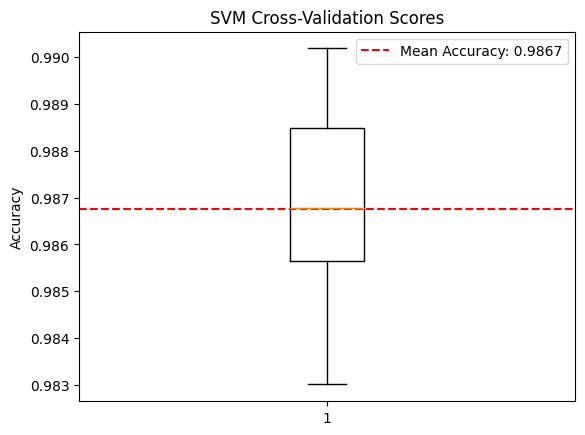

In [51]:
bplot(svm_cv_scores, svm_cv_mean, 'SVM Cross-Validation Scores')

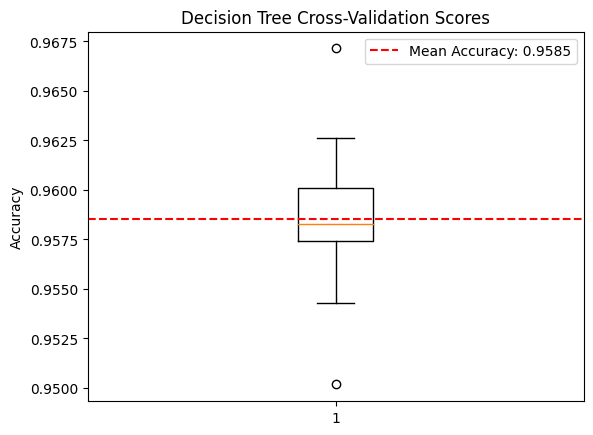

In [52]:
bplot(dt_cv_scores, dt_cv_mean, 'Decision Tree Cross-Validation Scores')

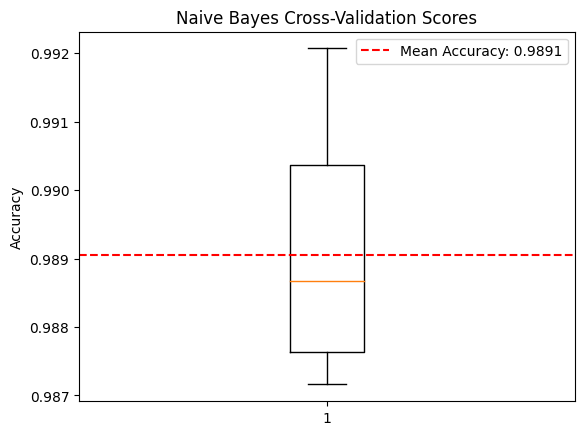

In [53]:
bplot(nb_cv_scores, nb_cv_mean, 'Naive Bayes Cross-Validation Scores')

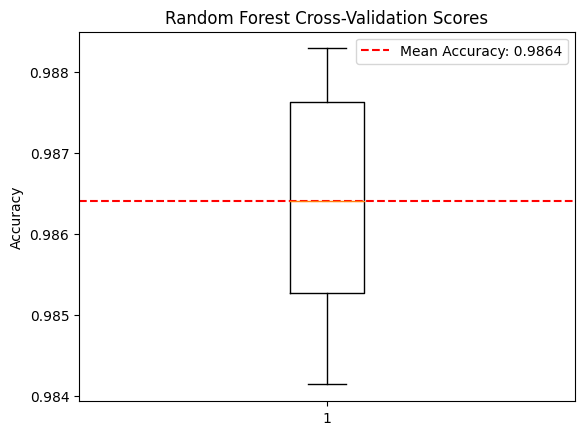

In [54]:
bplot(rf_cv_scores, rf_cv_mean, 'Random Forest Cross-Validation Scores')

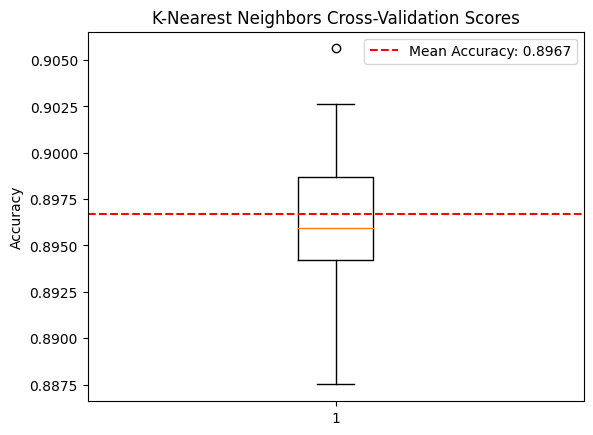

In [55]:
bplot(knn_cv_scores, knn_cv_mean, 'K-Nearest Neighbors Cross-Validation Scores')

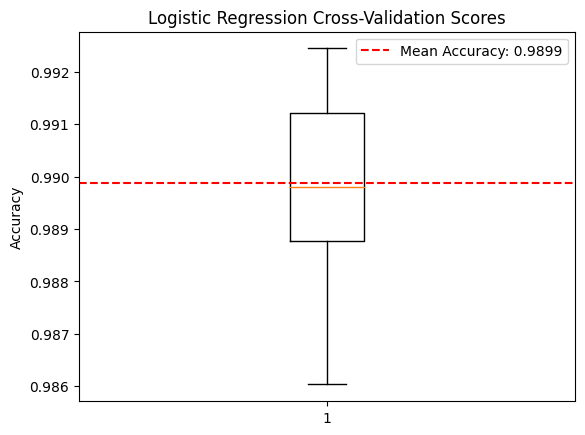

In [56]:
bplot(lr_cv_scores, lr_cv_mean, 'Logistic Regression Cross-Validation Scores')

Median values: [0.99, 0.96, 0.99, 0.99, 0.9, 0.99]


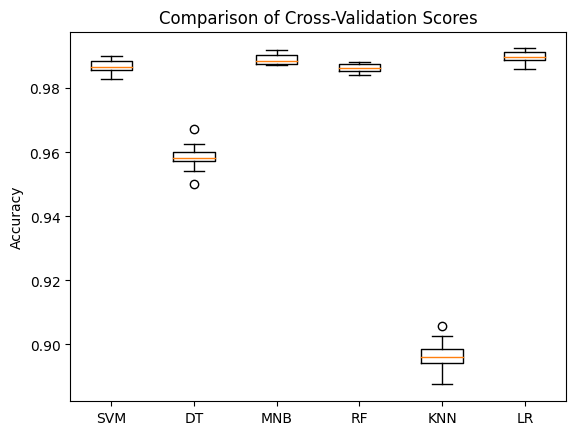

Median values: [0.99, 0.96, 0.99, 0.99, 0.99]


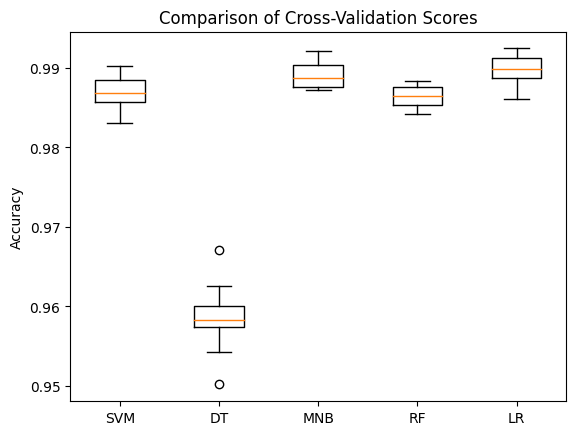

In [57]:
def comp_boxplots(data, labels):  
  fig, ax = plt.subplots()

  # Convert the NumPy arrays to tuples
  data = [tuple(d) for d in data]

  # Create the box plots using the boxplot() function
  bp = ax.boxplot(data)
  plt.title('Comparison of Cross-Validation Scores')

  # Set the labels for the x-axis and y-axis
  ax.set_xticklabels(labels)
  ax.set_ylabel('Accuracy')

  # Access the median values and print them to console
  medians = [round(median.get_ydata()[0], 2) for median in bp['medians']]
  print("Median values:", medians)

  # Show the plot
  plt.show()

data = [svm_cv_scores, dt_cv_scores, nb_cv_scores, rf_cv_scores, knn_cv_scores, lr_cv_scores]
x_labels = ['SVM', 'DT', 'MNB', 'RF', 'KNN', 'LR']
comp_boxplots(data, x_labels)

# Boxplot without K-Nearest Neighbours
data = [svm_cv_scores, dt_cv_scores, nb_cv_scores, rf_cv_scores, lr_cv_scores]
x_labels = ['SVM', 'DT', 'MNB', 'RF', 'LR']
comp_boxplots(data, x_labels)

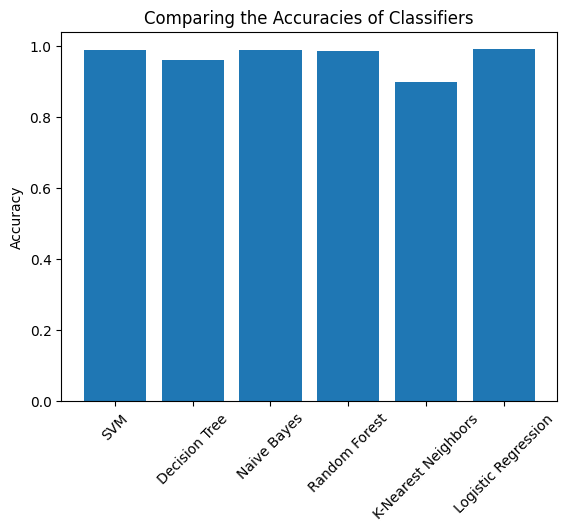

In [58]:
means = [svm_cv_mean, dt_cv_mean, nb_cv_mean, rf_cv_mean, knn_cv_mean, lr_cv_mean]
names = ['SVM', 'Decision Tree', 'Naive Bayes', 'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression']

# create bar chart
plt.bar(range(len(means)), means)

# add labels and title
plt.ylabel('Accuracy')
plt.xticks(range(len(means)), names, rotation=45)
plt.title('Comparing the Accuracies of Classifiers')

# show the chart
plt.show()

In [59]:
print(ham_prec_scores)
print(spam_prec_scores)
print(ham_f1_scores)
print(spam_f1_scores)
print(accuracy_scores)

[0.988, 0.964, 0.988, 0.987, 0.946, 0.995]
[0.972, 0.926, 0.978, 0.978, 0.79, 0.974]
[0.979, 0.942, 0.983, 0.982, 0.833, 0.984]
[0.98, 0.945, 0.983, 0.982, 0.866, 0.984]
[0.98, 0.944, 0.983, 0.982, 0.851, 0.984]


In [60]:
results = pd.DataFrame({ 'Classifier': models,    
    'Ham F-1': ham_f1_scores,
    'Spam F-1': spam_f1_scores,
    'Accuracy': accuracy_scores})
results

,Classifier,Ham F-1,Spam F-1,Accuracy
0,Support Vector Machine,0.979,0.980,0.980
1,Decision Tree,0.942,0.945,0.944
2,Multinomial Naive Bayes,0.983,0.983,0.983
3,Random Forest,0.982,0.982,0.982
4,K-NearestNeighbors,0.833,0.866,0.851
5,Logistic Regression,0.984,0.984,0.984


In [61]:
results.sort_values(by=['Accuracy', 'Spam F-1', 'Ham F-1'], ascending=False)

,Classifier,Ham F-1,Spam F-1,Accuracy
5,Logistic Regression,0.984,0.984,0.984
2,Multinomial Naive Bayes,0.983,0.983,0.983
3,Random Forest,0.982,0.982,0.982
0,Support Vector Machine,0.979,0.980,0.980
1,Decision Tree,0.942,0.945,0.944
4,K-NearestNeighbors,0.833,0.866,0.851


Each classifier proves to be very effective in the detection of spam emails. The least effective is the K-Nearest Neighbours classifier, possibly due to the data being very high dimensional. 


The Logistic Regression, Multinomial Naive Bayes and Random Forest are the most accurate within a very small margin.